- [ ] Import Libraries
- [ ] Select Device
- [ ] Setting hyperparameters
- [ ] Transforms
- [ ] Define Dataset
- [ ] Data Loader
- [ ] Visualization Dataset
- [ ] Build Network
    - [ ] 3x3 Conv
    - [ ] Residual Block
    - [ ] ResNet
- [ ] Visualization Network
- [ ] Loss and Optimizer
- [ ] Training
- [ ] Testing
- [ ] Save Model



###  Import Libraries

In [3]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Select Device ( GPU or CPU)

we will select device. there are two options: GPU or CPU. GPU technology is so faster than CPU technology. We will select GPU device. If your System is not include GPU technology, our function select CPU device.

In [39]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

### Hyperparameters

Hyper Paramaeters change each network and there is no rule to select hyper parameters. so we select most uses variable.

In [53]:
num_epochs = 8
batch_size = 100
learning_rate = 0.001

### Transforms

In [6]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

### Define Dataset

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

Files already downloaded and verified


### Data Loader

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

 ### Visualization Dataset

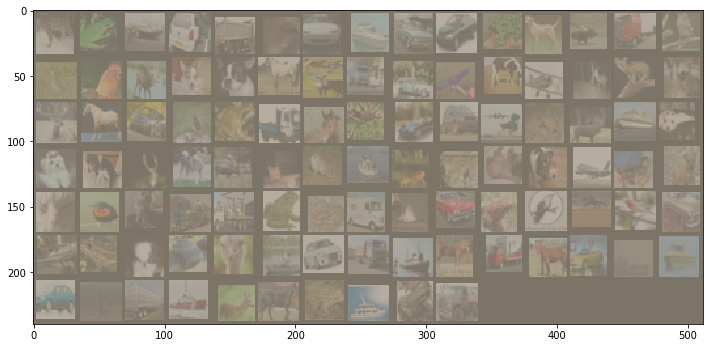

In [9]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=15)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,24))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

## Build Network

### 3x3 Convolution

In [10]:
def conv3x3( in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size= 3, 
                    stride= stride, padding = 1, bias = False)

### Residual Block

In [11]:
class ResidualBlock( nn.Module ):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None ):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU( inplace= True)
        
        self.conv2 = conv3x3( out_channels,  out_channels)
        self.bn2 = nn.BatchNorm2d( out_channels )
        self.downsample = downsample
        
    def forward( self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

### ResNet

In [50]:
class ResNet( nn.Module ):
    def __init__( self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        
        self.avg_pool = nn.AvgPool2d(8)
        
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer( self, block, out_channels, blocks, stride= 1 ):
        downsample = None
        
        if ( stride != 1 ) or ( self.in_channels != out_channels):
            downsample = nn.Sequential( 
            conv3x3(self.in_channels, out_channels, stride = stride),
            nn.BatchNorm2d(out_channels))
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view( out.size(0), -1)
        out = self.fc(out)
        
        return out
    
model = ResNet(ResidualBlock, [2,2,2]).to(device)
    

### Visualization Network

In [ ]:
model = ResNet(ResidualBlock, [2,2,2])
x = torch.randn(3, 3, 256, 256).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

### Loss and Optimizer

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Training

In [54]:
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/8], Step [100/500] Loss: 1.4320
Epoch [1/8], Step [200/500] Loss: 1.1213
Epoch [1/8], Step [300/500] Loss: 1.1870
Epoch [1/8], Step [400/500] Loss: 1.0615
Epoch [1/8], Step [500/500] Loss: 1.2079
Epoch [2/8], Step [100/500] Loss: 1.0507
Epoch [2/8], Step [200/500] Loss: 1.0555
Epoch [2/8], Step [300/500] Loss: 1.1870
Epoch [2/8], Step [400/500] Loss: 1.0356
Epoch [2/8], Step [500/500] Loss: 0.9342
Epoch [3/8], Step [100/500] Loss: 0.9616
Epoch [3/8], Step [200/500] Loss: 0.9470
Epoch [3/8], Step [300/500] Loss: 1.0380
Epoch [3/8], Step [400/500] Loss: 0.7265
Epoch [3/8], Step [500/500] Loss: 1.0094
Epoch [4/8], Step [100/500] Loss: 0.8742
Epoch [4/8], Step [200/500] Loss: 0.7062
Epoch [4/8], Step [300/500] Loss: 0.7882
Epoch [4/8], Step [400/500] Loss: 0.6956
Epoch [4/8], Step [500/500] Loss: 0.7093
Epoch [5/8], Step [100/500] Loss: 0.6482
Epoch [5/8], Step [200/500] Loss: 0.7314
Epoch [5/8], Step [300/500] Loss: 0.9785
Epoch [5/8], Step [400/500] Loss: 0.7032
Epoch [5/8], Ste

### Testing

In [55]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))



Accuracy of the model on the test images: 74.25 %


### Save Model

In [56]:
torch.save(model.state_dict(), 'resnet.ckpt')


- [x] Import Libraries
- [x] Select Device
- [x] Setting hyperparameters
- [x] Transforms
- [x] Define Dataset
- [x] Data Loader
- [x] Visualization Dataset
- [x] Build Network
    - [x] 3x3 Conv
    - [x] Residual Block
    - [x] ResNet
- [x] Visualization Network
- [x] Loss and Optimizer
- [x] Training
- [x] Testing
- [x] Save Model